# Load data and code.

In [1]:
%matplotlib inline

In [114]:
import sys
sys.path.append('../src/')
import etl, regressors, reporting, utilities, scipy.stats
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import os.path

In [108]:
for mod in regressors, etl, reporting:
    reload(mod)


2250 of 12945 columns have >50.0% NaN values
2366 of 12945 keys columns are constant.
3805 keys dropped (29.4%).

Train predictors are shape (2121, 95317)
Challenge predictors shape (2121, 95317)
Train responses are shape (2121, 6)
5489295 NaNs.
0 NaNs.
36.4 sec elapsed imputing predictors by most_frequent.
4487 NaNs.
0 NaNs.
0.0 sec elapsed imputing Ytrain by most_frequent.
Saving to ../data/preprocessed.npz.
342.5 sec elapsed preprocessing.


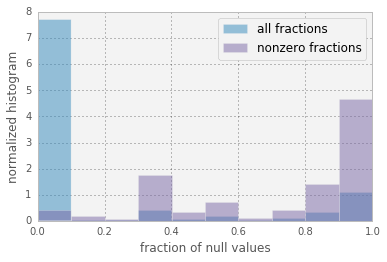

In [55]:
data = etl.Data(notebook=True, loadIfPossible=False, debug=False, imputationMethodY='most_frequent')

# Create and train estimators.

In [56]:
estimators = [
    regressors.Estimator('ridge'),
    regressors.Estimator('lasso'),
    regressors.Estimator('elasticNet', alpha=2.0),
    regressors.Estimator('svm', 3),
]

In [58]:
data.Ytrain.shape, data.Xtrain.shape, data.XtrainSubset.shape, len(data.idTrain), len(data.idTest)

((2121, 6), (2121, 95311), (2000, 95311), 2121, 2121)

In [66]:
data.Xchallenge.shape

(2121, 95311)

In [59]:
for estimator in estimators:
    with utilities.timeit('fitting %s' % estimator.method):
        estimator.fit(*data.train)

7.7 sec elapsed fitting ridge.
160.0 sec elapsed fitting lasso.
153.4 sec elapsed fitting elasticNet.


In [109]:
# estimators.append(regressors.Estimator('svm', 3))

In [110]:
# est = estimators[-1]
# with utilities.timeit('fitting %s' % est):
#     est.fit(*data.train)


921.9 sec elapsed fitting svm(3).


In [111]:
metrics = {}
for estimator in estimators:
    with utilities.timeit('evaluating %s' % estimator):
        metrics[estimator] = reporting.Metrics(estimator, data)
        metrics[estimator].r2
# metrics.saveToFile('../doc/metrics.tex')

2.9 sec elapsed evaluating Estimator: ridge.
2.6 sec elapsed evaluating Estimator: lasso.
2.6 sec elapsed evaluating Estimator: elasticNet(alpha=2.0).
985.6 sec elapsed evaluating svm(3).


In [116]:
str(metrics.values()[0])

'<reporting.Metrics object at 0x7feb626066d0>'

In [117]:
metricsTable = reporting.MetricsTable([metrics[est] for est in estimators])
print str(metricsTable)
metricsTable.write(os.path.join(data.dataDir, '..', 'doc'))

\begin{center}
\begin{tabular}{rcc}
\hline
 & \textbf{$\hat{r^2}$ (train)} & \textbf{$\hat{r^2}$ (test)} \\
\hline
\textbf{ridge} & 0.999999 & -0.771324 \\
\textbf{lasso} & 0.243894 & -0.066203 \\
\textbf{elasticNet($\alpha$=2.0)} & 0.265761 & -0.063879 \\
\textbf{svm(3)} & 0.804006 & -0.106628 \\
\hline
\end{tabular}
\end{center}


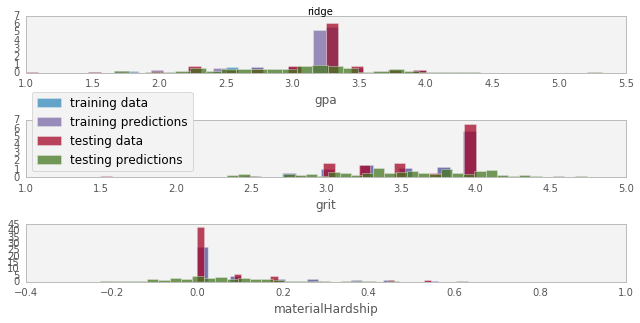

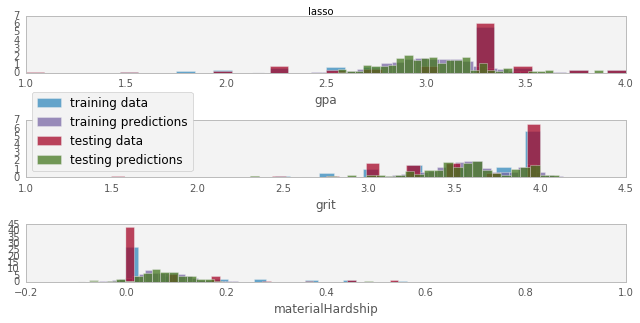

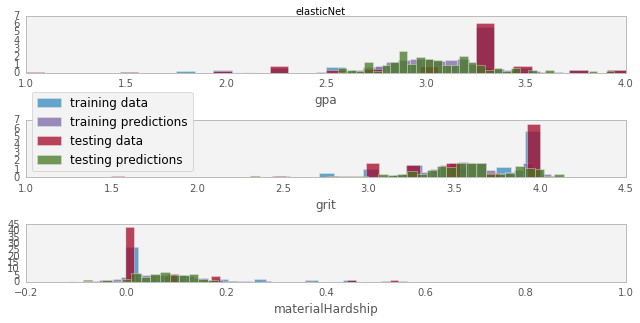

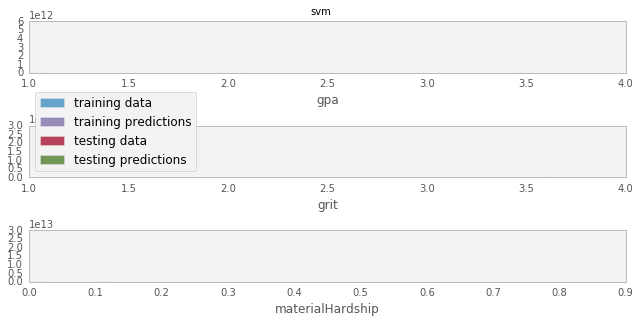

In [118]:
for estimator in estimators:
    figaxes = metrics[estimator].compareAllResponseHistograms()
    figaxes[0].suptitle(estimator.method)
    figaxes[0].tight_layout()
    figaxes[0].savefig(os.path.join(data.dataDir, '..', 'doc', 'responseHistograms_%s.pdf' % estimator.method))

In [119]:
for estimator in estimators:
    print '%s metrics: %s' % (estimator, metrics[estimator].r2)

Estimator: ridge metrics: {'test': -0.7713235842124796, 'train': 0.99999925104789933}
Estimator: lasso metrics: {'test': -0.066203024076940717, 'train': 0.24389413617604946}
Estimator: elasticNet(alpha=2.0) metrics: {'test': -0.063878987434709766, 'train': 0.26576104440936715}
svm(3) metrics: {'test': -0.10662811443182241, 'train': 0.8040062320707716}


In [120]:
best = np.argmax([
    metric.r2['test']
    for metric in [
        metrics[estimator]
        for estimator in estimators
    ]
])

In [121]:
metrics[estimators[best]].r2

{'test': -0.063878987434709766, 'train': 0.26576104440936715}

In [123]:
str(estimators[best])

'Estimator: elasticNet(alpha=2.0)'

# Generate CSV file to upload to FF site.

In [124]:
predictionChallenge = estimators[best].predict(data.Xchallenge)
predictionFullTrain = estimators[best].predict(data.Xtrain)

Collect all predicted variables.

In [125]:
numericColumnHeadings = [
    data.responseKeys[i]
    for i in range(len(data.responseKeys))
    if data.notCatResp[i]
]
toSave = {
    k: np.hstack([
        predictionFullTrain[:, i],
        predictionChallenge[:, i],
    ]).T
    for (i, k) in enumerate(numericColumnHeadings)
}
toSave['challengeID'] = np.hstack([
    data.idTrain, data.idTest
]).T

In [126]:
numericColumnHeadings

['gpa', 'grit', 'materialHardship']

Also include the unpredicted variables; as modes.

In [127]:
nonnumericColumnHeadingsEnumeration = [
    (i, data.responseKeys[i])
    for i in range(len(data.responseKeys))
    if not data.notCatResp[i]
]

npred = toSave['challengeID'].size
toSave.update({
    k: np.ones((npred,))*scipy.stats.mode(data.Ytrain[:, i])[0]
    for (i, k) in nonnumericColumnHeadingsEnumeration
})

In [128]:
predictiondf = pd.DataFrame(toSave)

In [129]:
predictiondf[:4]

,challengeID,eviction,gpa,grit,jobTraining,layoff,materialHardship
0,2882,0.0,2.999789,3.500599,0.0,0.0,-0.044450
1,2533,0.0,2.988947,3.610253,0.0,0.0,0.140239
2,2118,0.0,3.048876,3.563954,0.0,0.0,0.059673
3,1434,0.0,2.823155,3.629237,0.0,0.0,0.131731


In [130]:
import os.path
predictiondf.to_csv(os.path.join(data.dataDir, '..', 'prediction.csv'), index=False)

In [131]:
len(predictiondf)

4242